# [실험A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)

##### - MSE와 CrossEntropy가 학습 성능에 미치는 차이 분석
##### - 학습 곡선의 수렴 속도, 정확도, loss 안정성 비교

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



In [ ]:

batch_size = 64
epochs = 100
lr = 0.001




▶ Running experiment: CrossEntropy Loss
[CrossEntropy Loss] Epoch 1 | Train Loss: 1.4771 | Test Acc: 0.6596
[CrossEntropy Loss] Epoch 2 | Train Loss: 0.7479 | Test Acc: 0.7473
[CrossEntropy Loss] Epoch 3 | Train Loss: 0.6173 | Test Acc: 0.7911
[CrossEntropy Loss] Epoch 4 | Train Loss: 0.5474 | Test Acc: 0.8059
[CrossEntropy Loss] Epoch 5 | Train Loss: 0.5070 | Test Acc: 0.8158
[CrossEntropy Loss] Epoch 6 | Train Loss: 0.4817 | Test Acc: 0.8248
[CrossEntropy Loss] Epoch 7 | Train Loss: 0.4659 | Test Acc: 0.8217
[CrossEntropy Loss] Epoch 8 | Train Loss: 0.4510 | Test Acc: 0.8297
[CrossEntropy Loss] Epoch 9 | Train Loss: 0.4398 | Test Acc: 0.8378
[CrossEntropy Loss] Epoch 10 | Train Loss: 0.4300 | Test Acc: 0.8306
[CrossEntropy Loss] Epoch 11 | Train Loss: 0.4220 | Test Acc: 0.8411
[CrossEntropy Loss] Epoch 12 | Train Loss: 0.4142 | Test Acc: 0.8396
[CrossEntropy Loss] Epoch 13 | Train Loss: 0.4069 | Test Acc: 0.8422
[CrossEntropy Loss] Epoch 14 | Train Loss: 0.4002 | Test Acc: 0.8469
[C

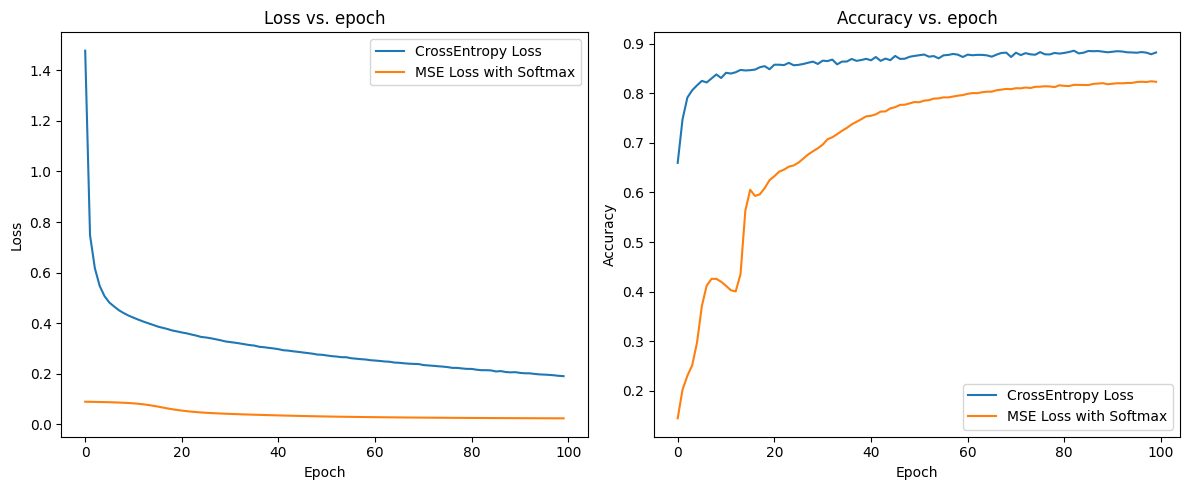

In [ ]:

# 데이터 로딩
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #모델 순전파
        # 
        # 28*28이미지를 1차원 벡터로 변환 
        x = x.view(-1, 28*28)

        # 활성화 함수로는 relu 활용
        # 효과적인 결과를 위해 full conneted 은닉층은 2층으로 구성
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        #출력층
        x = self.fc3(x)
        return x

# 훈련 함수
def train(model, loss_fn, optimizer, use_softmax=False):
    model.train()
    total_loss, correct = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if use_softmax:
            output = F.softmax(output, dim=1)
            target_onehot = F.one_hot(target, num_classes=10).float()
            loss = loss_fn(output, target_onehot)
        else:
            loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# 테스트 함수
def evaluate(model, loss_fn, use_softmax=False):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if use_softmax:
                output = F.softmax(output, dim=1)
                target_onehot = F.one_hot(target, num_classes=10).float()
                loss = loss_fn(output, target_onehot)
            else:
                loss = loss_fn(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# 실험 실행 함수
def run_experiment(loss_fn, use_softmax=False, label=""):
    model = MLP().to(device)
    #옵티마이저-아담으로 했을 때, 비정상적인 결과나옴.
    #SGD+momentum 사용
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_losses, test_accs = [], []

    print(f"\n▶ Running experiment: {label}")
    for epoch in range(epochs):

        #.forward 자동적으로 호출
        train_loss, train_acc = train(model, loss_fn, optimizer, use_softmax)
        test_loss, test_acc = evaluate(model, loss_fn, use_softmax)
        print(f"[{label}] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}")
        train_losses.append(train_loss)
        test_accs.append(test_acc)
    return train_losses, test_accs

# 실험 실행
ce_losses, ce_accs = run_experiment(nn.CrossEntropyLoss(), use_softmax=False, label="CrossEntropy Loss")
mse_losses, mse_accs = run_experiment(nn.MSELoss(), use_softmax=True, label="MSE Loss with Softmax")

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label="CrossEntropy Loss")
plt.plot(mse_losses, label="MSE Loss with Softmax")
plt.title("Loss vs. epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ce_accs, label="CrossEntropy Loss")
plt.plot(mse_accs, label="MSE Loss with Softmax")
plt.title("Accuracy vs. epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
